<a href="https://colab.research.google.com/github/DaniChinwendu/ML-FOR-COMPUTATIONAL-TOXICOLOGY/blob/main/EWC_2_DPRA%2Ch_CLAT%2CARE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import files and read Hirota's dataset
import io
from google.colab import files
uploaded=files.upload()
import pandas as pd
import numpy as np
df=pd.read_csv(io.BytesIO(uploaded['Hirota_2015_Updated_Clean_092515 (2).csv']))
df["CASRN"] = df["CASRN"].astype(str)
df.index = df["CASRN"]
df.head()

Saving Hirota_2015_Updated_Clean_092515 (2).csv to Hirota_2015_Updated_Clean_092515 (2).csv


,CASRN,Chemical,LLNAthreshold,logLLNAthreshold,logMinhCLAT,logDPRA,logImax,logMAC,EC3,LLNA_Threshold,GHS_Category,hCLAT_Call,DPRA_Call,ARE_Call,SH_Call,Pred_LLNAthreshold,Pred_PotencyCategory,LLNA_Category
CASRN,,,,,,,,,,,,,,,,,,
886-38-4,886-38-4,Diphenylcyclopropenone,0.003,-2.5229,0.593,1.7118,1.2281,2.666,0.003,0.003,1A,P,P,P,P,0.35,Extreme or Strong,Extreme
15646-46-5,15646-46-5,Oxazolone,0.003,-2.5229,0.433,1.6390,0.2086,1.765,0.003,0.003,1A,P,P,P,P,0.20,Extreme or Strong,Extreme
1897-45-6,1897-45-6,Chlorothalonil,0.004,-2.3979,-0.678,1.7071,1.2956,1.702,0.004,0.004,1A,P,P,P,P,0.02,Extreme or Strong,Extreme
mixture,mixture,MCI/MI,0.005,-2.3010,0.344,1.7292,0.4691,1.794,0.005,0.005,1A,P,P,P,P,0.13,Extreme or Strong,Extreme
106-51-4,106-51-4,"1,4-Benzoquinone",0.01,-2.0044,0.350,1.9680,1.7092,1.614,0.01,0.01,1A,P,P,P,P,0.13,Extreme or Strong,Extreme


In [2]:
#import all library and dependecies
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate,LeaveOneOut,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import warnings # supress warnings
from sklearn import metrics
from numpy import mean
from numpy import absolute
from numpy import sqrt
warnings.filterwarnings('ignore')

In [3]:
#drop all incomplete datapiont
df1=df.dropna(subset=['logDPRA','logImax'])
len(df1)

69

In [4]:
#import Read Cosmetic Europe in vitro data, physchem properties, OECD Toolbox predictions
uploaded=files.upload()
df2=pd.read_csv(io.BytesIO(uploaded['CosEu_invitro_insilico_128chems_Jan2017.csv']))
df2["CASRN"] = df2["CASRN"].str.strip()
df2 = df2.sort_values(by="Num")
df2=df2

Saving CosEu_invitro_insilico_128chems_Jan2017.csv to CosEu_invitro_insilico_128chems_Jan2017.csv


In [5]:
#Replace negative values in DPRA.mean column with 0
df2['DPRA.mean']=df2['DPRA.mean'].clip(lower=0)
# Remove rows with missing values in DPRA.Call or hCLAT.Call columns
df2.dropna(subset=['DPRA.Call','hCLAT.Call'],inplace=True)


In [6]:
#Import and read in vivo LLNA and human data
uploaded=files.upload()
df3=pd.read_csv(io.BytesIO(uploaded['CosEu_invivo_128chems_March2017.csv']))

Saving CosEu_invivo_128chems_March2017.csv to CosEu_invivo_128chems_March2017.csv


In [7]:
# select the rows where LLNA.Call.MNC is equal to 0
df3['Median_NC.EC3'].fillna(0, inplace=True)
# select the rows where LLNA.Call.MNC is equal to 0
df3['Median_NC.EC3'].replace(0,100,inplace=True)

In [8]:
# remove the period (.) character from the column names and
# replace multiple consecutive periods with underscores
df3.columns = [col.replace(".", "").replace("(\\.)+", "_") for col in df3.columns]
# Check if all values in cosEuNegCons['Num'] are contained in cosEu['Num']
#if all(df3["Num"].isin(df2["Num"])):
# Merge the two data frames on the Num column
CosEu= pd.merge(df2,df3, on="Num", sort=False)
# Replace instances of "CASRN.x" in column names with "CASRN"
CosEu.columns = CosEu.columns.str.replace("CASRN.x", "CASRN")
CosEu.columns = CosEu.columns.str.replace("Median_NCEC3_x", "Median_NCEC3")

# Set the row names to the values in the CASRN column
CosEu.index = CosEu["CASRN"]
CosEu["logLLNAthreshold"]=df1["logLLNAthreshold"]

# Create a new column and store the logarithm (base 10) of the values in the Median_NC_EC3 column
CosEu['log_Median_NC_EC3'] = np.log10(CosEu["Median_NCEC3"])

# Replace missing values in logLLNAthresholdMedNegCons with corresponding values in logLLNAthreshold
CosEu["log_Median_NC_EC3"].mask(
    CosEu['log_Median_NC_EC3'].isna(),
    CosEu["logLLNAthreshold"],
    inplace=True,)


In [9]:
#Applying logic to deal with negatives (If all model inputs are negative, prediction is negative)
#CosEu['MODEL_PRED1']='Pos'
col_list=["DPRA.Call","hCLAT.Call",'KS.Call']
CosEu['Pos.Call.DH']=CosEu[col_list].sum(axis=1)
CosEu['Model_pred']=CosEu['Pos.Call.DH'].apply(lambda x:'Neg' if x==0 else 'Pos')

In [10]:
#Replace negatives in hCLAT with CV75
CosEu['hCLAT.MIT']=CosEu['hCLAT.MIT'].replace(['Inf'], np.inf)
CosEu.loc[CosEu['hCLAT.MIT'] == np.inf, 'hCLAT.MIT'] = CosEu.loc[CosEu['hCLAT.MIT'] == np.inf, 'h.CLAT.CV75']
#Convert all h_CLAT Value to log 10 values
CosEu['log_hCLAT_MIT']=np.log10(CosEu['hCLAT.MIT'])
CosEu['log_KS.Imax']=np.log10(CosEu['KS.Imax'])


In [11]:
#Replace 0 in DPRA with 0.01
CosEu['DPRA.mean']=CosEu['DPRA.mean'].clip(lower=0.01)
CosEu['log_DPRA_mean']=np.log10(CosEu['DPRA.mean'])
CosEu.head(2)

,Num,Chemical_x,CASRN,U-SENS.Call,U-SENS.CD86.EC150,U-SENS.CV70,DPRA.Call,DPRA.percCysdep,DPRA.percLysdep,DPRA.mean,...,humanCall,humanpotency3class,humanpotency5class,logLLNAthreshold,log_Median_NC_EC3,Pos.Call.DH,Model_pred,log_hCLAT_MIT,log_KS.Imax,log_DPRA_mean
CASRN,,,,,,,,,,,,,,,,,,,,,
35691-65-7,2,Methyldibromo glutaronitrile,35691-65-7,1.0,3,5,1.0,100.0,28.6,64.30,...,1,Strong,Strong,-0.0458,-0.045757,3.0,Pos,0.974051,0.605305,1.808211
149-30-4,3,2-Mercaptobenzothiazole,149-30-4,1.0,40,80,1.0,97.5,0.0,48.75,...,1,Weak,Moderate,0.2304,0.414973,3.0,Pos,1.759668,0.945961,1.687975


In [12]:
#Checking for intesection between hirotashi dataset and merged invivo, invitro dataset using the CAS column
#strip x suffix and prefix
CosEu.columns = CosEu.columns.str.rstrip('_x')
merge = pd.merge(df1, CosEu, left_index=True, right_index=True,how='right')
ex_data=merge[['log_Median_NC_EC3','log_DPRA_mean','log_hCLAT_MIT','log_KS.Ima','Model_pred']]
ex_data['log_hCLAT_MIT'].replace('inf','NA',inplace=True)
ex_data= ex_data.replace('inf', np.NaN)
ex_data.dropna(subset=['log_hCLAT_MIT','log_DPRA_mean'], inplace=True)
ex_data.head(98)
ex_data.head(2)
len(ex_data)

127

In [13]:
CosEu1=ex_data[ex_data['Model_pred']!='Neg']
CosEu1.dropna()
len(CosEu1)
CosEu1['log_Median_NC_EC3'].isna().sum()
CosEu1[['log_DPRA_mean','log_hCLAT_MIT']].isna().sum()

log_DPRA_mean    0
log_hCLAT_MIT    0
dtype: int64

In [97]:
#Defining target and predictors
TargetVariable=['logLLNAthreshold']
Predictors=['logMinhCLAT','logDPRA','logImax']
X=df1[Predictors].values
y=df1[TargetVariable].values
PredictorScaler=MinMaxScaler()
TargetVarScaler=MinMaxScaler()
#Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
# Generating the standardized values of X and y
scaled_X=PredictorScalerFit.transform(X)
scaled_y=TargetVarScalerFit.transform(y)

In [98]:
#Scale the external dataset using the previous scaling object 
TargetVariable=['log_Median_NC_EC3']
Predictors=['log_hCLAT_MIT','log_DPRA_mean','log_KS.Ima']
X=CosEu1[Predictors]
y=CosEu1[TargetVariable]
PredictorScalerFitex=PredictorScaler.fit(X)
TargetVarScalerFitex=TargetVarScaler.fit(y)
# Generating the standardized values of X and y
ex_x=PredictorScalerFitex.transform(X)
ex_y=TargetVarScalerFitex.transform(y)
ex_y.shape

(115, 1)

In [94]:
X.

,log_hCLAT_MIT,log_DPRA_mean,log_KS.Ima
CASRN,,,
35691-65-7,0.974051,1.808211,0.605305
149-30-4,1.759668,1.687975,0.945961
104-55-2,1.008600,1.755494,1.210586
137-26-8,0.431364,1.725912,0.829304
69-72-7,2.784546,1.089905,0.053078
...,...,...,...
101-39-3,1.605305,1.292256,2.142483
111-80-8,1.962843,1.712650,1.519303
93-51-6,1.488551,0.759668,0.008600


In [49]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(55, 3)
(55, 1)
(14, 3)
(14, 1)


In [50]:
#Develop and train the model
reg = MLPRegressor(hidden_layer_sizes=(5,2),activation='relu',random_state=42, learning_rate_init=0.02,momentum=0.7, max_iter=500,solver='lbfgs')
# Predict the target values on the test data
reg.fit(X_train, y_train)
#check train and test score
train_score=reg.score(X_train, y_train)
test_score=reg.score(X_test, y_test)
print('train-score',train_score)
print('test_score',test_score)

train-score 0.5879282259289398
test_score 0.7295123261341553


In [51]:
#predict the test set with model and check accuracies(r2 score and MSE)
y_pred=reg.predict(X_test)
print("The Score with ",(r2_score(y_pred, y_test)))
print("The Score with ",(mean_squared_error(y_pred, y_test)))

The Score with  0.6977714334125467
The Score with  0.007175913725386493


In [19]:
len(y_test)
len(y_pred)

14

5 FOLD CROSS VALIDATION TRAIN SET

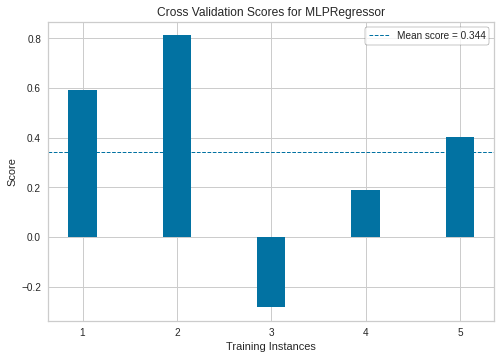

CVScores(ax=<AxesSubplot:title={'center':'Cross Validation Scores for MLPRegressor'}, xlabel='Training Instances', ylabel='Score'>,
         cv=KFold(n_splits=5, random_state=0, shuffle=True),
         estimator=MLPRegressor(hidden_layer_sizes=(5, 2),
                                learning_rate_init=0.02, max_iter=500,
                                momentum=0.7, random_state=42, solver='lbfgs'),
         scoring='r2')

In [20]:
cv = KFold(n_splits=5, random_state=0, shuffle=True)
#validation score for cv=
from yellowbrick.model_selection import cv_scores
cv_scores(
    reg,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    scoring='r2',
    random_state=42)

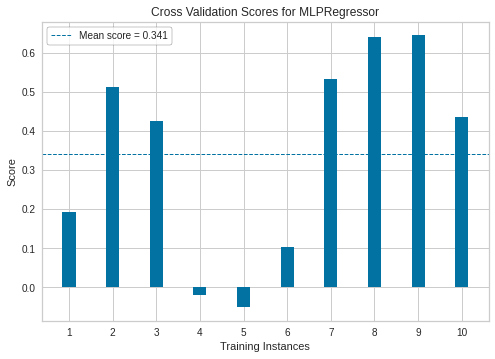

CVScores(ax=<AxesSubplot:title={'center':'Cross Validation Scores for MLPRegressor'}, xlabel='Training Instances', ylabel='Score'>,
         cv=KFold(n_splits=10, random_state=42, shuffle=True),
         estimator=MLPRegressor(hidden_layer_sizes=(5, 2),
                                learning_rate_init=0.02, max_iter=500,
                                momentum=0.7, random_state=42, solver='lbfgs'),
         scoring='r2')

In [21]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)
# validation score for cv=10
from yellowbrick.model_selection import cv_scores
cv_scores(
    reg,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    scoring='r2',
    random_state=0)

5-FOLD CROSS VALIDATION

In [22]:
#implementing the 5 fold cross validation for r2 score on train set
cv = KFold(n_splits=5, random_state=28, shuffle=True)
#scoring=['neg_mean_squared_error']
scores = cross_val_score(reg, X_train,y_train, scoring='r2', cv=cv)
scores.mean()

0.46524265179572344

In [23]:
#implementing the 5 fold cross validation for MSE & RMSE on train set
cv = KFold(n_splits=5, random_state=0, shuffle=True)
#scoring=['neg_mean_squared_error']
scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
RMSE=sqrt(mean(absolute(scores)))
MSE=(mean(absolute(scores)))
print('the root mean squared erro',RMSE)
print('the mean squared error',MSE)


the root mean squared erro 0.1945417665423021
the mean squared error 0.03784649892939957


In [24]:
#model performance for predicted outcomes after 5-fold cross validation
pred = cross_val_predict(reg, X_train, y_train, cv=cv)

R2 = metrics.r2_score(y_train, pred)
MSE=metrics.mean_squared_error(y_train, pred)
RMSE=sqrt(MSE)
print('r2 after CV',R2)
print ('MSE AFTER CV:', MSE)
print('RMSE AFTER CV:',RMSE)

r2 after CV 0.5215884752210198
MSE AFTER CV: 0.037846498929399564
RMSE AFTER CV: 0.19454176654230207


5 FOLD CROSS VALIDATION FOR TEST SET

In [25]:
#implementing the 5 fold cross validation for r2 score on test set
cv = KFold(n_splits=5, random_state=0, shuffle=True)
scores = cross_val_score(reg, X_test,y_test, scoring='r2', cv=cv)
scores.mean()

-1.0148343350994435

In [26]:
#implementing the 5 fold cross validation for MSE & RMSE on test set
cv = KFold(n_splits=5, random_state=28, shuffle=True)
scores = cross_val_score(reg, X_test, y_test, scoring='neg_mean_squared_error', cv=cv)
RMSE=sqrt(mean(absolute(scores)))
MSE=(mean(absolute(scores)))
print('the root mean squared erro',RMSE)
print('the mean squared error',MSE)

the root mean squared erro 0.1478042892622152
the mean squared error 0.021846107924308585


In [27]:
#model performance for predicted outcomes after 5-fold cross validation
pred = cross_val_predict(reg, X_test, y_test, cv=cv)
R2 = metrics.r2_score(y_test, pred)
MSE=metrics.mean_squared_error(y_test, pred)
RMSE=sqrt(MSE)
print('r2 after CV',R2)
print ('MSE AFTER CV:', MSE)
print('RMSE AFTER CV:',RMSE)

r2 after CV 0.11926935413297302
MSE AFTER CV: 0.02336537942642184
RMSE AFTER CV: 0.15285738263630527


TEN FOLD CROSS VALIDATION TRAIN SET

In [28]:
#implementing the 10 fold cross validation for r2 score on  train set
cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(reg, X_train,y_train, scoring='r2', cv=cv)
scores.mean()

0.34124312923123956

In [29]:
#implementing the 10 fold cross validation for RMSE & MSE on train set
cv = KFold(n_splits=10, random_state=4, shuffle=True)
pred_cv1 = cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
RMSE=sqrt(mean(absolute(pred_cv1)))
MSE=(absolute(mean(pred_cv1)))
print('the root mean squared erro',RMSE)
print('the mean squared error',MSE)

the root mean squared erro 0.18906890627355896
the mean squared error 0.03574705131947982


In [30]:
#model performance for predicted outcomes after 5-fold cross validation
pred = cross_val_predict(reg, X_train, y_train, cv=cv)
R2 = metrics.r2_score(y_train, pred)
MSE=metrics.mean_squared_error(y_train, pred)
RMSE=sqrt(MSE)
print('r2 after CV',R2)
print ('MSE AFTER CV:', MSE)
print('RMSE AFTER CV:',RMSE)

r2 after CV 0.530525013324014
MSE AFTER CV: 0.03713954129516664
RMSE AFTER CV: 0.19271621959546278


TEN FOLD CROSS VALIDATION TEST SET

In [31]:
#implementing the 10 fold cross validation for r2 score on  train set
cv = KFold(n_splits=10, random_state=42, shuffle=True)
#scoring=['neg_mean_squared_error']
scores = cross_val_score(reg, X_train,y_train, scoring='r2', cv=cv)
scores.mean()

0.34124312923123956

In [32]:
#implementing the 10 fold cross validation for RMSE & MSE score the model for test set
cv = KFold(n_splits=10, random_state=0, shuffle=True)
#scoring=['neg_mean_squared_error']
scores = cross_val_score(reg, X_test,y_test, scoring='neg_mean_squared_error', cv=cv)
RMSE=sqrt(mean(absolute(scores)))
MSE=(absolute(mean(scores)))
print('the root mean squared erro',RMSE)
print('the mean squared error',MSE)

the root mean squared erro 0.15677231025655694
the mean squared error 0.024577557263178153


In [33]:
pred = cross_val_predict(reg, X_test, y_test, cv=cv)
R2 = metrics.r2_score(y_test, pred)
MSE=metrics.mean_squared_error(y_test, pred)
RMSE=sqrt(MSE)
print('r2 after CV',R2)
print ('MSE AFTER CV:', MSE)
print('RMSE AFTER CV:',RMSE)

r2 after CV -0.06564883299410473
MSE AFTER CV: 0.02827117397932603
RMSE AFTER CV: 0.1681403401308741


LEAVE OUT ONE CROSS VALIDATION TRAIN SET


In [34]:
#EVALUATING THE MODEL WITH LEAVE ONE OUT On train set
cv=LeaveOneOut()
scores = cross_val_score(reg,X_train, y_train, scoring='neg_mean_squared_error',cv=cv)
RMSE=sqrt(mean(absolute(scores)))
MSE=(absolute(mean(scores)))
print('the root mean squared erro',RMSE)
print('the mean squared error',MSE)

the root mean squared erro 0.2036890164500833
the mean squared error 0.04148921542240231


In [35]:
cv=LeaveOneOut()
pred = cross_val_predict(reg, X_train, y_train, cv=cv)
R2 = metrics.r2_score(y_train, pred)
MSE=metrics.mean_squared_error(y_train, pred)
RMSE=sqrt(MSE)
print('r2 after CV',R2)
print ('MSE AFTER CV:', MSE)
print('RMSE AFTER CV:',RMSE)

r2 after CV 0.475541480094577
MSE AFTER CV: 0.04148921542240231
RMSE AFTER CV: 0.2036890164500833


In [36]:
cv=LeaveOneOut()
y_pred = cross_val_predict(reg, X_train, y_train, cv=cv)
r2_loocv= r2_score(y_pred,y_train)
print(r2_loocv)

0.12379092719935314


LEAVE OUT ONE CROSS VALIDATION TEST SET

In [37]:
cv=LeaveOneOut()
scores = cross_val_score(reg,X_test, y_test, scoring='neg_mean_squared_error',cv=cv)
RMSE=sqrt(mean(absolute(scores)))
MSE=(absolute(mean(scores)))
print('the root mean squared erro',RMSE)
print('the mean squared error',MSE)

the root mean squared erro 0.16576577108080487
the mean squared error 0.027478290862013803


In [38]:
cv=LeaveOneOut()
pred = cross_val_predict(reg, X_test, y_test, cv=cv)
R2 = metrics.r2_score(y_test, pred)
MSE=metrics.mean_squared_error(y_test, pred)
RMSE=sqrt(MSE)
print('r2 after CV',R2)
print ('MSE AFTER CV:', MSE)
print('RMSE AFTER CV:',RMSE)

r2 after CV -0.03576203136066769
MSE AFTER CV: 0.027478290862013803
RMSE AFTER CV: 0.16576577108080487


In [39]:
cv=LeaveOneOut()
y_pred = cross_val_predict(reg, X_train, y_train, cv=cv)
r2_loocv= r2_score(y_pred,y_train)
print(r2_loocv)

0.12379092719935314


GRID SERACH CV FOR SELECTING BEST OPTIMIZER AND ACTIVATION FUNCTION

In [40]:
cv=KFold(n_splits=5,shuffle=True,random_state=9)

In [41]:
#performing Gridsearch for TESTING DIFFERENT OPTIMIZER
# define the grid search parameters
model=reg
param = {
    'solver':['adam','sgd','ibfgs']}
search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.16089290052788677
Best Hyperparameters: {'solver': 'sgd'}


In [42]:
#Grid search for the best activation function
model=reg
param = {
    'activation':['relu','tahn','identity','softmax','logistics']}
search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5088599527487612
Best Hyperparameters: {'activation': 'relu'}


FINAL MODEL


In [46]:
y_test

array([[0.93344978, 0.7708992 , 1.        , 0.97238497, 0.84545314,
        0.87065821, 0.31528444, 0.84545314, 0.93344978, 0.8501404 ,
        0.70841717, 0.72659135, 0.76329346, 0.73753565]])

In [53]:
y_pred

array([0.79784195, 0.74724789, 0.85407619, 0.90048852, 0.94440321,
       0.80509218, 0.30056083, 0.91948157, 0.85100469, 0.8187002 ,
       0.7931046 , 0.62644152, 0.84089026, 0.80276724])

In [54]:
y_test=y_test.reshape(1,-1)
y_pred=y_pred.reshape(1,-1)

Text(0, 0.5, 'predictions')

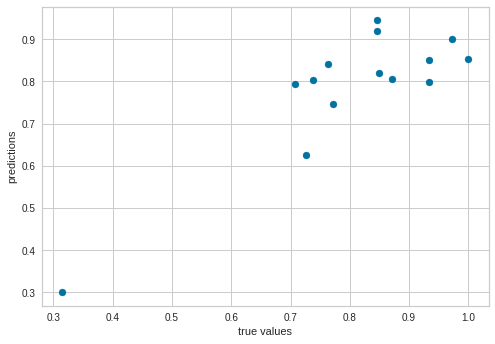

In [55]:
#Visualizing test and pred set
plt.scatter(y_test, y_pred)
plt.xlabel('true values')
plt.ylabel('predictions')

TESTING WITH EXTERNAL TEST SET

In [43]:
pred = reg.predict(ex_x)
r2 =r2_score(ex_y, pred)
MSE=mean_squared_error(ex_y, pred )
print(r2)
print(MSE)
RMSE=sqrt(MSE)
print(RMSE)
len(pred)

0.44225226747731305
0.03936784241875849
0.19841331210067154


115

CORRELATION METRICS FOR TEST AND PREDICTED OUTCOME

In [56]:
#CORRELATION FOR TEST and PREDICTED OUTCOME
corr_1 = np.corrcoef(y_test.ravel(), y_pred.ravel())
corr_1

array([[1.        , 0.86604014],
       [0.86604014, 1.        ]])

In [57]:
#COVARIANCE FOR TEST and PREDICTED OUTCOME
Cov=np.cov(y_test.ravel(), y_pred.ravel())
Cov

array([[0.02857027, 0.02340768],
       [0.02340768, 0.02556974]])

PREDICTING WITH THE EXTERNAL DATASET

Text(0, 0.5, 'predictions')

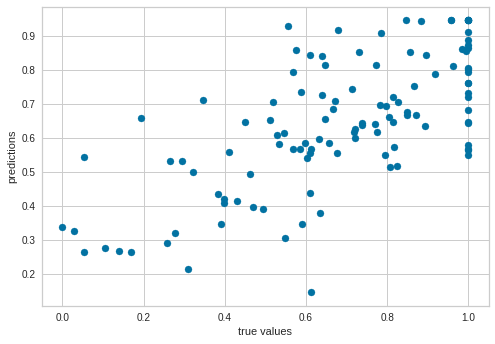

In [58]:
#Visualizing test and pred set
plt.scatter(ex_y, pred)
plt.xlabel('true values')
plt.ylabel('predictions')

CORRELATION METRICS for EXTERNAL DATA SET

In [59]:
print(ex_x.shape)
print(ex_y.shape)

(115, 3)
(115, 1)


In [60]:
ex_y.shape=(115,)#cHANGE SHAPE AND DIMENSION

In [61]:
#COVARIANCE FOR EXTERNALDATASET
Cov=np.cov(ex_y, pred )
Cov

array([[0.07120275, 0.03544696],
       [0.03544696, 0.03769888]])

In [62]:
#PEARSON CORRELATION  FOR EXTERNAL DATASET
corr_1=np.corrcoef(ex_y, pred )
corr_1

array([[1.        , 0.68417369],
       [0.68417369, 1.        ]])

In [63]:
#get the inverse transform of all predicted outcome via external dataset
def inverse_transform(y_pred):
  pred=TargetVarScalerFit.inverse_transform(y_pred)
  return pred

In [64]:
#reshape all predicted and target to 2d numpy array
ex_2d = ex_y.reshape(-1, 1)
ex_test=inverse_transform(ex_2d)
pred_2d = pred.reshape(-1, 1)
ex_pred=inverse_transform(pred_2d)

In [65]:
#Convert the to a dataframe
df_test = pd.DataFrame(ex_test)
df_pred=pd.DataFrame(ex_pred)

In [66]:
#Collect all required data for comparism
ANN_MODEL1=CosEu1[['log_DPRA_mean','log_hCLAT_MIT','log_KS.Ima']]
ANN_MODEL1['ANNmodel1_Set']="Test"
ANN_MODEL1=ANN_MODEL1.reset_index()
ANN_MODEL1['test_pred']=df_pred
ANN_MODEL1['Original_pred']=df_test
ANN_MODEL1=ANN_MODEL1.set_index('CASRN')

In [67]:
#Add predictions to main merged dataset
merge['Ewc_model_pred']=ANN_MODEL1['test_pred']
merge['Ewc_model_pred']=merge['Ewc_model_pred'].replace(np.nan,'Neg')

In [70]:
merge["EWC_Model1_Potency_Pred"] =np.nan
merge["EWC_Model1_Potency_Pred.3class"] = np.nan
merge['Ewc_model_pred'] = pd.to_numeric(merge['Ewc_model_pred'],errors='coerce')


In [71]:
# apply the conditions and labels
merge.loc[merge['Ewc_model_pred'] < (-1), "EWC_Model1_Potency_Pred" ] = 'Extreme'
merge.loc[(merge['Ewc_model_pred'] >= (-1)) & (merge['Ewc_model_pred'] < 0), "EWC_Model1_Potency_Pred"] = 'Strong'
merge.loc[(merge['Ewc_model_pred'] >= 0) & (merge['Ewc_model_pred'] < 1), "EWC_Model1_Potency_Pred"] = 'Moderate'
merge.loc[merge['Ewc_model_pred'] >= 1, "EWC_Model1_Potency_Pred"] = 'Weak'
merge.loc[merge['Ewc_model_pred'] >=np.nan, "EWC_Model1_Potency_Pred"] = 'Non'

In [69]:
# create the new column and set the initial values
merge["EWC_Model1_Potency_Pred.3class"] = merge["EWC_Model1_Potency_Pred"]
# apply the conditions and labels
merge.loc[merge["EWC_Model1_Potency_Pred"] == "Extreme", "EWC_Model1_Potency_Pred.3class"] = "Strong"
merge.loc[merge["EWC_Model1_Potency_Pred"] == "Moderate", "EWC_Model1_Potency_Pred.3class"] = "Weak"

# convert the column to a categorical variable with the specified levels
merge["EWC_Model1_Potency_Pred.3class"] = pd.Categorical(merge["EWC_Model1_Potency_Pred.3class"], categories=["Non", "Weak", "Strong"])

In [72]:
# create the new column and set the initial values
merge['EWC_Model1_Call'] = pd.NA
# apply the conditions and labels
merge.loc[merge["EWC_Model1_Potency_Pred"].notnull(), 'EWC_Model1_Call'] = 1
merge.loc[merge["EWC_Model1_Potency_Pred"].isnull(), 'EWC_Model1_Call'] = 0

In [91]:
merge["EWC_Model1_Potency_Pred"].unique()

array(['Moderate', 'Strong', 'Weak', nan], dtype=object)

In [92]:
merge['EWC_Model1_Call'].unique()

array([1, 0], dtype=object)

In [93]:
merge[["EWC_Model1_Potency_Pred",'EWC_Model1_Call']].head()

,EWC_Model1_Potency_Pred,EWC_Model1_Call
CASRN,,
35691-65-7,Moderate,1
149-30-4,Moderate,1
104-55-2,Moderate,1
137-26-8,Strong,1
69-72-7,Weak,1


In [94]:
merge[['Ewc_model_pred',"EWC_Model1_Potency_Pred"]]

,Ewc_model_pred,EWC_Model1_Potency_Pred
CASRN,,
35691-65-7,0.029886,Moderate
149-30-4,0.580185,Moderate
104-55-2,0.009900,Moderate
137-26-8,-0.362351,Strong
69-72-7,1.493339,Weak
...,...,...
101-39-3,0.432608,Moderate
111-80-8,0.669744,Moderate
93-51-6,0.631268,Moderate


In [95]:
merge['EWC_Model1_Potency_Pred.3class']=merge['EWC_Model1_Potency_Pred.3class'].fillna('Non')

In [96]:
merge['EWC_Model1_Call'] = merge['EWC_Model1_Call'].astype('int64')

<AxesSubplot:>

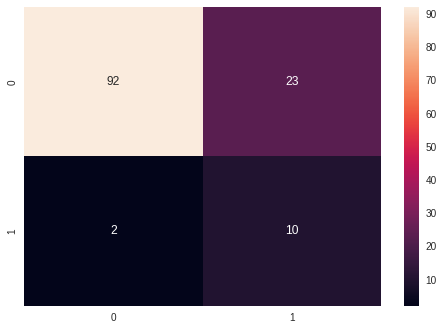

In [97]:
import pandas as pd
from sklearn.metrics import confusion_matrix
# create the confusion matrix for LLNA harzard
cm=confusion_matrix(merge['EWC_Model1_Call'], merge['LLNACallMNC'], labels=[1,0])
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

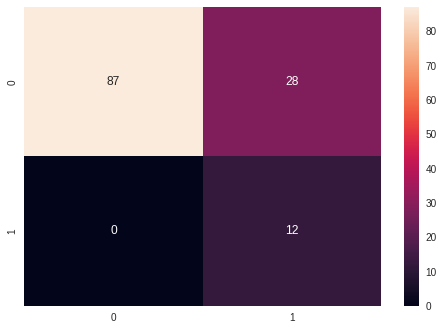

In [98]:
# Binary Class accuracy usisng human data
hm=confusion_matrix(merge['EWC_Model1_Call'], merge['humanCall'], labels=[1,0])
sns.heatmap(hm, annot=True, fmt='d')

<AxesSubplot:>

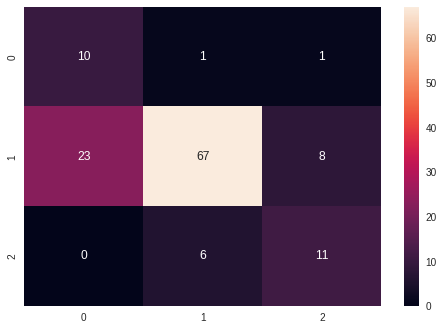

In [99]:
# convert the columns to categorical variables with the specified levels
merge['LLNApotency3classMNC'] = pd.Categorical(merge['LLNApotency3classMNC'], categories=["Non", "Weak", "Strong"])
merge['EWC_Model1_Potency_Pred.3class'] = pd.Categorical(merge['EWC_Model1_Potency_Pred.3class'], categories=["Non", "Weak", "Strong"])
# create the confusion matrix
llna_3c=confusion_matrix(merge['EWC_Model1_Potency_Pred.3class'], merge['LLNApotency3classMNC'], labels=["Non", "Weak", "Strong"])
sns.heatmap(llna_3c, annot=True, fmt='d')

<AxesSubplot:>

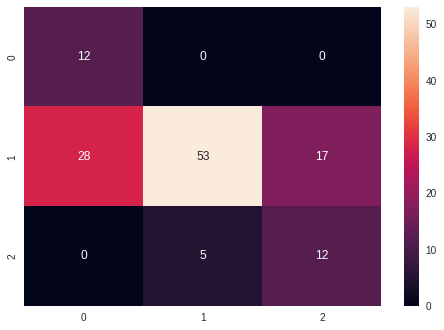

In [100]:
# create the confusion matrix for 3 class potency and human data 
hu_3c=confusion_matrix(merge['EWC_Model1_Potency_Pred.3class'], merge['humanpotency3class'], labels=["Non", "Weak", "Strong"])
sns.heatmap(hu_3c, annot=True, fmt='d')

In [73]:
import pickle

In [74]:
#collect the model object file
filename ='EWC_2.pkl' 
pickle.dump(reg,open(filename,'wb'))

In [75]:
file='minmax_scaler.pkl'
pickle.dump(PredictorScalerFit,open(file,'wb'))

In [76]:
file_name='minmax_target.pkl'
pickle.dump(TargetVarScalerFit,open(file_name,'wb'))

In [77]:
model = pickle.load(open(filename,'rb'))
pred=model.predict(ex_x)

In [78]:
TargetVariable=['log_Median_NC_EC3']
Predictors=['log_hCLAT_MIT','log_DPRA_mean','log_KS.Ima']
X=CosEu1[Predictors]
y=CosEu1[TargetVariable]
PredictorScalerFitex=PredictorScaler.fit(X)
TargetVarScalerFitex=TargetVarScaler.fit(y)
# Generating the standardized values of X and y
ex_x=PredictorScalerFitex.transform(X)
ex_y=TargetVarScalerFitex.transform(y)
ex_y.shape

(115, 1)

In [79]:
pred

array([0.42020344, 0.58215405, 0.41432173, 0.30476958, 0.85089175,
       0.69578937, 0.29099475, 0.32419647, 0.26311357, 0.32021028,
       0.27477104, 0.26793151, 0.26379338, 0.54416854, 0.53206076,
       0.21352813, 0.73376618, 0.34549574, 0.40702712, 0.49781844,
       0.85595048, 0.53188778, 0.64634121, 0.70989199, 0.39538536,
       0.39054475, 0.65067152, 0.79136422, 0.14530826, 0.8119373 ,
       0.55576492, 0.55630079, 0.87148384, 0.56713887, 0.43414403,
       0.597456  , 0.74378637, 0.37885322, 0.64200227, 0.61573514,
       0.62409485, 0.69370198, 0.64446349, 0.57343979, 0.71846853,
       0.75010039, 0.67599572, 0.94440321, 0.66510588, 0.51259251,
       0.94440321, 0.56566524, 0.860122  , 0.63687992, 0.85030497,
       0.65894097, 0.90977533, 0.81007134, 0.94440321, 0.94440321,
       0.86196126, 0.8020932 , 0.64194394, 0.94440321, 0.70421822,
       0.83945317, 0.81233178, 0.61434606, 0.63337041, 0.94184757,
       0.75943569, 0.78726999, 0.54847886, 0.88754546, 0.94440

In [80]:
target = pickle.load(open(file_name,'rb'))
target.inverse_transform([pred])

array([[ 0.02988608,  0.58018454,  0.00990039, -0.36235126,  1.4933391 ,
         0.96631052, -0.4091573 , -0.29633987, -0.50389589, -0.30988468,
        -0.46428451, -0.48752481, -0.50158593,  0.45111204,  0.40997055,
        -0.67238422,  1.09535343, -0.22396621, -0.01488628,  0.29361718,
         1.51052838,  0.40938276,  0.79828866,  1.01423039, -0.05444429,
        -0.07089239,  0.8130028 ,  1.29106813, -0.90419126,  1.36097424,
         0.49051586,  0.49233671,  1.5633098 ,  0.52916384,  0.07725536,
         0.63217965,  1.12940147, -0.1106195 ,  0.78354518,  0.69429105,
         0.72269685,  0.9592177 ,  0.79190828,  0.55057399,  1.04337296,
         1.15085613,  0.89905289,  1.81108543,  0.86204986,  0.3438186 ,
         1.81108543,  0.52415653,  1.52470294,  0.76613974,  1.49134526,
         0.84110189,  1.69342199,  1.35463379,  1.81108543,  1.81108543,
         1.53095264,  1.32752458,  0.78334699,  1.81108543,  0.99495124,
         1.4544715 ,  1.36231466,  0.68957104,  0.7

In [81]:
#collect the model and min-max object file
filename ='EWC_2.pkl' 
scaler='minmax_scaler.pkl'
target='minmax_target.pkl'

def load_model():
    return pickle.load(open(filename,'rb'))

def load_scaler():
    return pickle.load(open(scaler,'rb'))


def target_scaler():
    return pickle.load(open(target,'rb'))



model = load_model()
scaler = load_scaler()
target_scaler=target_scaler()


In [82]:
def inverse_transform(y_pred):
  pred=target_scaler.inverse_transform([y_pred])
  return pred

In [83]:
import numpy as np
def convert_to_log10(input):
  log=np.log10(input)
  return log

In [84]:
def prediction_LOGEC3(X, scaler, model):
    # Scale the input
    scaled_input = scaler.transform(X)
    prediction = model.predict(scaled_input)
    return prediction

In [86]:
DPRA_LysD =float(input("DPRA LysD:"))
DPRA_CysD =float(input("DPRA CysD: "))
log_DPRA_mean = (DPRA_LysD + DPRA_CysD) / 2 
log_DPRA_mean=convert_to_log10(log_DPRA_mean) 
log_DPRA_mean



DPRA LysD:28.6
DPRA CysD: 100


1.808210972924222

In [87]:
CD86_EC150=float(input("CD86_EC150: " ))
CD54_EC200 =float(input("CD54_EC200 ", ))
CV75 =float(input("CV75:" ))
log_hCLAT_MIT = min(CD86_EC150, CD54_EC200, CV75)
log_hCLAT_MIT=convert_to_log10(log_hCLAT_MIT )
log_hCLAT_MIT


CD86_EC150: 10.8
CD54_EC200 9.42
CV75:9.9


0.9740509027928773

In [88]:
log_KSImax=float(input("KSIma:"))
log_KSImax=convert_to_log10(log_KSImax)
log_KSImax

KSIma:4.03


0.6053050461411095

In [101]:
 X= np.array([[log_hCLAT_MIT,log_DPRA_mean,log_KSImax]])
 result = prediction_LOGEC3(X, scaler, model)
 result = inverse_transform(result)
 result

array([[0.02988608]])

In [102]:
!pip install streamlit --quiet
!npm install -g localtunnel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
/tool

In [106]:
%%writefile app.py
import numpy as np
import pickle
import pandas as pd
import streamlit as st 
#collect the model object file
#collect the model and min-max object file
filename ='EWC_2.pkl' 
scaler='minmax_scaler.pkl'
target='minmax_target.pkl'

def load_model():
    return pickle.load(open(filename,'rb'))

def load_scaler():
    return pickle.load(open(scaler,'rb'))


def target_scaler():
    return pickle.load(open(target,'rb'))



model = load_model()
scaler = load_scaler()
target_scaler=target_scaler()


def welcome():
    return "Welcome All"

def inverse_transform(y_pred):
  pred=target_scaler.inverse_transform([y_pred])
  return pred


def prediction_LOGEC3(X, scaler, model):
    # Scale the input
    scaled_input = scaler.transform(X)
    prediction = model.predict(scaled_input)
    return prediction

def convert_to_log10(input):
  log=np.log10(input)
  return log

def main():
    st.title("'EDELWEISS CONNECT ITS SKIN SENSITIZATION SOLUTION'")
    st.markdown('An Artificial Neural Network Regression model Utilizing invitro and inchemo(h-CLAT,DPRA,KSIma) Descriptors for predicting skin Sensitization')
    html_temp = """
    EWC_1 SKIN SENSITIZATION PREDICTION App 
    """
    if st.button('INFORMATION ABOUT THIS WEB APP BEFORE USE'):
          st.write("The Edelweiss ITS skin sensitization model predicts the Murine local lymph node assay (LLNA) EC3 value of a substance. The model uses Adverse Outcome Pathway data obtained from in-chemo and invitro assays to reflect the underlying immune response that leads to skin sensitization.")
          st.write('TRAIN DATA')
          st.write('The EWC-1 model is trained with the data obtained from the Direct peptide reactivity assay (DPRA). This is  an in-chemo assay that measure a substance ability to form hapten-protein complex. Results from DPRA reflects the molecular initiating event in AOP for skin sensitization and it is the first key event in Skin Sensitization Adverse outcome pathway.')
          st.write('The model is trained on Human cell line activation assay data(h-CLAT). h-CLAT also known as human Cell line activation assay is an in-vitro test that access the ability of a substance to induce or mobilize dendric cell in the skin')
          st.write('WEB APP INPUT')
          st.write('The Web app utilizes log transformed input data for DPRA and h-CLAT. to aid robust and précised prediction capabilities the model accepts the following input parameter. The model accepts this input and automatically select the right input used for making prediction.')
          st.write('DPRA – Average of DPRA Lysine AND DPRA Cystine Depletion Values')
          st.write('h-CLAT - Maximum of CD86-EC150, CD54-EC200, and CV75')
    st.markdown(html_temp, unsafe_allow_html=True)
    DPRA_LysD = st.number_input("DPRA LysD", min_value=0.1, max_value=100.0, value=1.0, step=1.0,)
    DPRA_CysD = st.number_input("DPRA CysD", min_value=0.1, max_value=100.0, value=1.0, step=1.0,)
    log_DPRA_mean = (DPRA_LysD + DPRA_CysD) / 2
    log_DPRA_mean=convert_to_log10(log_DPRA_mean)
    
    CD86_EC150= st.number_input("CD86_EC150 ", min_value=1.0, max_value=5000.0, value=1.0, step=1.0)
    CD54_EC200 = st.number_input("CD54_EC200 ", min_value=1.0, max_value=5000.0, value=1.0, step=1.0)
    CV75 = st.number_input("CV75", min_value=1.0, max_value=5000.0, value=10.0, step=1.0,)
    log_hCLAT_MIT = min(CD86_EC150, CD54_EC200, CV75)
    log_hCLAT_MIT=convert_to_log10(log_hCLAT_MIT )

    log_KSImax=st.number_input("KSIma",min_value=1.0, max_value=500.0, value=1.0, step=1.0)
    log_KSImax=convert_to_log10(log_KSImax)
    X= np.array([[log_hCLAT_MIT,log_DPRA_mean,log_KSImax]])
    
    #prediction_type = st.selectbox("Select prediction type:", ["Two-class", "Three-class"])
    if st.button("Predict"):
    # Scale the input
    
    # Call the prediction function
      result = prediction_LOGEC3(X, scaler, model)
    # Convert the prediction back to the original scale
      
      result = inverse_transform(result)
      EC3_Value=result
      
      if result is not None:
        if float(result) < (-1):
          result = 'Strong'
        elif float(result) >= (-1) and float(result) < 0:
          result = 'Strong'
        elif float(result) >= 0 and float(result) < 1:
          result = 'Moderate'
        elif float(result) >= 1:
          result = 'Moderate'
        else:
          result = 'Non'
        
        st.success(f'The EC3 value is {EC3_Value} and the chemical potency is {result}')
    
if __name__=='__main__':
    main()
      

Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[#######...........] \ diffTrees: sill install generateActionsToTake


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.139.12.129:8501

npx: installed 22 in 3.599s
your url is: https://cuddly-signs-swim-34-139-12-129.loca.lt
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
else:
            if float(result) < (-1):
                result = 'Positive'
            elif float(result) >= (-1) and float(result) < 0:
                result = 'Positive'
            elif float(result) >= 0 and float(result) < 1:
                result = 'Positive'
            elif float(result) >= 1:
                result = 'Positive'
            else:
                result = 'Negative'

In [122]:
import pickle
import numpy as np

# Function to load the trained model
def load_model():
    return pickle.load(open('EWC_2.pkl', 'rb'))

# Function to load the scaler for predictor variables
def load_predictor_scaler():
    return pickle.load(open('minmax_scaler.pkl', 'rb'))

# Function to load the scaler for target variable
def load_target_scaler():
    return pickle.load(open('minmax_target.pkl', 'rb'))

# Function to apply inverse transformation on predicted target variable
def inverse_transform(y_pred):
    target_scaler = load_target_scaler()
    pred = target_scaler.inverse_transform([y_pred])
    return pred

# Function to convert input to log10 scale
def convert_to_log10(input):
    log = np.log10(input)
    return log

# Function to make prediction using loaded model and scalers
def prediction_LOGEC3(X):
    model = load_model()
    predictor_scaler = load_predictor_scaler()
    # Scale the input
    scaled_input = predictor_scaler.transform(X)
    # Make prediction
    prediction = model.predict(scaled_input)
    # Apply inverse transform to get back the original scale
    prediction = inverse_transform(prediction)
    return prediction

# Take input from user
DPRA_LysD = float(input("DPRA LysD: "))
DPRA_CysD = float(input("DPRA CysD: "))
log_DPRA_mean = (DPRA_LysD + DPRA_CysD) / 2 
log_DPRA_mean = convert_to_log10(log_DPRA_mean) 
CD86_EC150 = float(input("CD86_EC150: "))
CD54_EC200 = float(input("CD54_EC200: "))
CV75 = float(input("CV75: "))
log_hCLAT_MIT = min(CD86_EC150, CD54_EC200, CV75)
log_hCLAT_MIT = convert_to_log10(log_hCLAT_MIT)
log_KSImax = float(input("KSIma: "))
log_KSImax = convert_to_log10(log_KSImax)
X = np.array([[log_DPRA_mean, log_hCLAT_MIT, log_KSImax]])

# Make prediction using deployed model
result = prediction_LOGEC3(X)

# Print the predicted value
print("Predicted value: ", result)


DPRA LysD: 28.6
DPRA CysD: 100
CD86_EC150: 10.8
CD54_EC200: 9.42
CV75: 9.9
KSIma: 4.03
Predicted value:  [0.76883775]
